In [256]:
import os
import csv

from matplotlib import pyplot as plt
import numpy as np

from collections import Counter

In [257]:
import os
import math
import csv
from collections import Counter

from matplotlib import pyplot as plt
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [258]:
def open_in_domain_file(label_name:str) :
    label_sentences = []
    data_sentences = []
    with open(os.getcwd() + '\\CoLa\\original\\tokenized\\in_domain_'+label_name+'.tsv') as file :
        rd = csv.reader(file, delimiter="\t")
        for row in rd:
            data_sentences.append(list(row[3].lower().split()))
            label_sentences.append(int(row[1]))
    return data_sentences, label_sentences

In [259]:
def create_vocabulary(data:list) :
    vocab, index = {}, 1  # start indexing from 1
    vocab['<pad>'] = 0  # add a padding token
    for tokens in data :
        for token in tokens:
            if token not in vocab:
                vocab[token] = index
                index += 1
    return vocab

In [260]:
def apply_text_transformation(vocab:dict, data:list) :
    sequenced_data = []
    for tokens in data :
        sequenced_data.append([])
        for i,token in enumerate(tokens):
            if token in vocab:
                sequenced_data[-1].append(vocab[token])
            else :
                sequenced_data[-1].append(0)
    return sequenced_data

In [261]:
def normalize_vector_size(max_size:int, data:list) :
    for i,it in enumerate(data) :
        if len(it) < max_size :
            it += [0] * (max_size - len(it)) 
        else :
            data[i] = it[:max_size]

# Preprocessing

In [262]:
training_sentences_tokenized = []
training_sentences_label = []
training_sentences_sequenced = []

test_sentences_tokenized = []
test_sentences_label = []
test_sentences_sequenced = []

vocab = {}

In [263]:
training_sentences_tokenized,training_sentences_label = open_in_domain_file('train') # import training sentences
vocab = create_vocabulary(training_sentences_tokenized) # create vocabulary with
training_sentences_sequenced = apply_text_transformation(vocab, training_sentences_tokenized) # encode word in all sentences
training_counter = Counter([len(it) for it in training_sentences_sequenced])

In [264]:
print(len(vocab))

5419


In [265]:
test_sentences_tokenized, test_sentences_label = open_in_domain_file('dev') # import training sentences
vocab = create_vocabulary(test_sentences_tokenized) # create vocabulary with
test_sentences_sequenced = apply_text_transformation(vocab, test_sentences_tokenized) # encode word in all sentences
testing_counter = Counter([len(it) for it in test_sentences_sequenced])

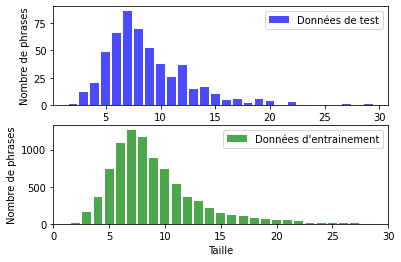

In [266]:
x_training = np.array([it for it in training_counter.keys()])
y_training = np.array([it for it in training_counter.values()])
x_testing = np.array([it for it in testing_counter.keys()])
y_testing = np.array([it for it in testing_counter.values()])

plt.figure()

plt.subplot(211)
plt.bar(x_testing, y_testing, color ="blue",alpha=0.7, label='Données de test')
plt.ylabel("Nombre de phrases")
plt.xlabel("Taille")
plt.legend(loc='best')

plt.subplot(212)
plt.bar(x_training, y_training, color ="green", alpha=0.7, label='Données d\'entrainement')
plt.ylabel("Nombre de phrases")
plt.xlabel("Taille")
plt.legend(loc='best')
ax = plt.gca()
ax.set_xlim([0, 30])
plt.savefig(os.getcwd() + '/data/fig/CoLa_sentences_repartition.png', bbox_inches='tight')

In [267]:
normalize_vector_size(25, training_sentences_sequenced) # normalize with
normalize_vector_size(25, test_sentences_sequenced) # normalize with

# Training

In [268]:
x = np.array(training_sentences_sequenced, dtype=object)
y = np.array(training_sentences_label)
print(x.shape)
print(y.shape)

(8551, 25)
(8551,)


## SVM

In [269]:
clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_svm.fit(x, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

## Logistic Regression

In [270]:
clf_regression = LogisticRegression(random_state=0, max_iter=1000)
clf_regression.fit(x, y)

LogisticRegression(max_iter=1000, random_state=0)

# Testing

## SVM

In [271]:
error_svm = []
error_sentences_svm = []
for i, test_tokens in enumerate(test_sentences_sequenced) :
    if clf_svm.predict([test_tokens]) != test_sentences_label[i] :
        error_svm.append(len(test_sentences_tokenized[i]))
        error_sentences_svm.append((test_tokens, i))


In [272]:
print(len(error_svm)*100/len(test_sentences_sequenced))

30.36053130929791


## Logistic Regression

In [273]:
print(clf_regression.predict_proba([test_sentences_sequenced[46]]))

[[0.35039357 0.64960643]]


In [274]:
error_regression_size = []
error_sentences_regression = []
error_regression_proba = []
total_proba = []
for i, test_tokens in enumerate(test_sentences_sequenced) :
    proba = clf_regression.predict_proba([test_tokens])[0][0]
    total_proba.append(proba)
    if clf_regression.predict([test_tokens]) != test_sentences_label[i] :
        error_regression_size.append(len(test_sentences_tokenized[i]))
        error_regression_proba.append(proba)
        error_sentences_regression.append((test_tokens, i))
print(len(error_regression_size) * 100 / len(total_proba))

30.36053130929791


## Results

In [275]:
error_counter = Counter(error_regression_size)

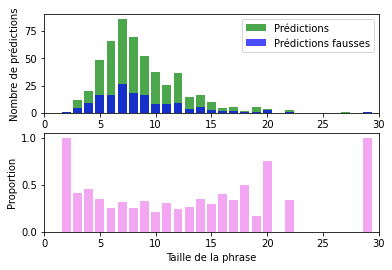

In [276]:
x = [it for it in testing_counter.keys()]

y_testing = np.array([it for it in testing_counter.values()])
y_error = []
for it in testing_counter.keys():
    if it in error_counter :
        y_error.append(error_counter[it])
    else :
        y_error.append(0)
y_error = np.array(y_error)
y_proportion = [y_error[i] / y_testing[i] for i in range(len(y_error))]

figure = plt.figure()
plt.subplot(211)
plt.bar(x, y_testing, color ="green", alpha=0.7, label='Prédictions')
plt.bar(x, y_error, color ="blue", alpha=0.7, label='Prédictions fausses')
plt.ylabel("Nombre de prédictions")
plt.xlabel("Taille de la phrase")
plt.legend(loc='best')
ax = plt.gca()
ax.set_xlim([0, 30])

plt.subplot(212)
plt.bar(x, y_proportion, color ="violet", alpha=0.7)
plt.ylabel("Proportion")
plt.xlabel("Taille de la phrase")
ax = plt.gca()
ax.set_xlim([0, 30])
plt.show()

figure.savefig(os.getcwd() + '/data/fig/CoLa_results_regression_proba_1.png', bbox_inches='tight')

In [277]:
import collections
def round_list(data:list) :
    newList = []
    for i in range(len(data)) :
        newList.append(round(data[i]*10)/10)
    return newList

error_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(error_regression_proba)).items())))
total_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(total_proba)).items())))
print(error_proba_counter)
print(total_proba_counter)

{0.3: 134, 0.4: 26}
{0.3: 451, 0.4: 76}


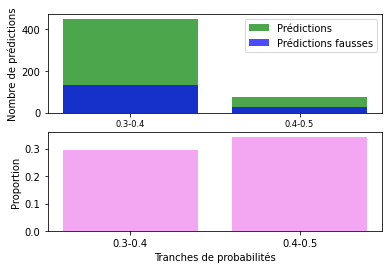

In [278]:
x = np.array([str(it)+'-'+str(round((it+0.1)*10)/10) for it in total_proba_counter.keys()])
y_testing = np.array([it for it in total_proba_counter.values()])
y_error = []
for it in total_proba_counter.keys():
    if it in error_proba_counter :
        y_error.append(error_proba_counter[it])
    else :
        y_error.append(0)
y_error = np.array(y_error)
y_proportion = [y_error[i] / y_testing[i] for i in range(len(y_error))]

figure = plt.figure()
plt.subplot(211)
plt.bar(range(len(y_testing)), y_testing, color ="green", alpha=0.7, label='Prédictions')
plt.bar(range(len(y_error)), y_error, color ="blue", alpha=0.7, label='Prédictions fausses')
plt.ylabel("Nombre de prédictions")
plt.xlabel("Taille de la phrase")
plt.xticks(range(len(y_testing)), x, size='small')
plt.legend(loc='best')

plt.subplot(212)
plt.bar(x, y_proportion, color ="violet", alpha=0.7)
plt.ylabel("Proportion")
plt.xlabel("Tranches de probabilités")
plt.show()
figure.savefig(os.getcwd() + '/data/fig/CoLa_results_regression_proba_2.png', bbox_inches='tight')

# Word2Vec 

## Preprocessing

In [279]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

def define_model(sentences:list, window:int, vector_size:int=5) :
    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=0, workers=4)
    return model

In [280]:
def transform_to_vec(model:object, data:list, max_sentence_size:int, vector_size:int) :
    newData = []
    for tokens in data :
        newData.append([])
        for token in tokens : 
            if token in model.wv :
                newData[-1] = list(np.concatenate([newData[-1], model.wv[token]]))
            else :
                 newData[-1] += [0]*vector_size
    normalize_vector_size(max_sentence_size*5, newData)
    return newData

## Training

In [281]:
def train(sentences_representation:list, sentences_label:list) :
    x = np.array(sentences_representation)
    y = np.array(sentences_label)

    clf_regression = LogisticRegression(random_state=0, max_iter=1000)
    clf_regression.fit(x, y)
    return clf_regression

## Testing

In [282]:
def test(model:object,clf_regression:object, test_sentences:list) :
    error_regression_size = []
    error_sentences_regression = []
    error_regression_proba = []
    total_proba = []
    for i, test_tokens in enumerate(test_sentences) :
        proba = clf_regression.predict_proba([test_tokens])[0][0]
        total_proba.append(proba)
        if clf_regression.predict([test_tokens]) != test_sentences_label[i] :
            error_regression_size.append(len(test_sentences_tokenized[i]))
            error_regression_proba.append(proba)
            error_sentences_regression.append((test_sentences_tokenized[i], i))
    accuracy = 100 - len(error_regression_size) * 100 / len(total_proba)
    return accuracy, error_regression_size, error_sentences_regression, error_regression_proba, total_proba

In [283]:
def workflow(window:int, vector_size:int) :
    model = define_model(training_sentences_tokenized, window, vector_size)
    training_sentences_embedded = transform_to_vec(model, training_sentences_tokenized, 25, vector_size)
    test_sentences_embedded = transform_to_vec(model, test_sentences_tokenized, 25, vector_size)
    clf_regression = train(training_sentences_embedded, training_sentences_label)
    accuracy, error_regression_size, error_sentences_regression, error_regression_proba, total_proba = test(model,clf_regression, test_sentences_embedded)
    return accuracy, error_regression_size, error_sentences_regression, error_regression_proba, total_proba

In [284]:
accuracy_window = []
accuracy_vector_size = []

for window in range(1, 10,2) :
    accuracy_window.append(workflow(window, 5)[0])
    
for vector_size in range(1, 10,2) :
    accuracy_vector_size.append(workflow(window, 5)[0])

In [285]:
print(accuracy_vector_size)
print(accuracy_window)

[69.63946869070209, 69.25996204933587, 69.63946869070209, 69.63946869070209, 69.63946869070209]
[69.44971537001898, 69.25996204933587, 69.44971537001898, 69.63946869070209, 69.44971537001898]


c:\users\charl\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\users\charl\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


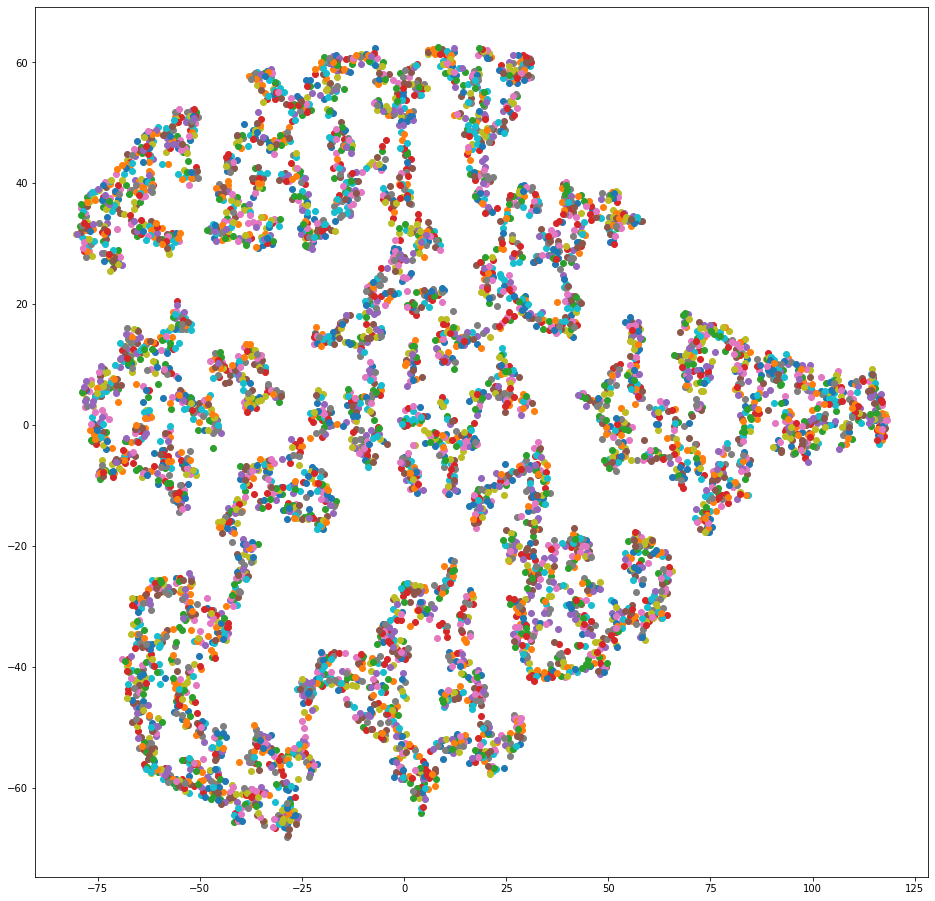

In [82]:
model = define_model(training_sentences_tokenized, 2, 2)
tsne_plot(model)

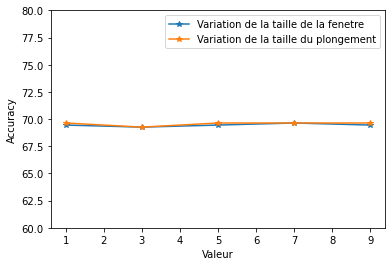

In [286]:
x = range(1,10,2)
y_window = np.array(accuracy_window)
y_size = np.array(accuracy_vector_size)
fig=plt.figure()
plt.plot(x,y_window,'*-', label='Variation de la taille de la fenetre')
plt.plot(x,y_size,'*-', label='Variation de la taille du plongement')
plt.legend(loc='best')
ax = plt.gca()
ax.set_ylim([60, 80])
plt.ylabel("Accuracy")
plt.xlabel("Valeur")
plt.show()
fig.savefig(os.getcwd() + '/data/fig/CoLa_results_regression_variation_size_1.png', bbox_inches='tight')

In [287]:
accuracy, error_regression_size, error_sentences_regression, error_regression_proba, total_proba = workflow(2,5)

In [288]:
error_counter = Counter(error_regression_size)

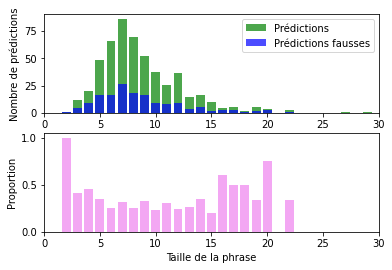

In [289]:
x = [it for it in testing_counter.keys()]

y_testing = np.array([it for it in testing_counter.values()])
y_error = []
for it in testing_counter.keys():
    if it in error_counter :
        y_error.append(error_counter[it])
    else :
        y_error.append(0)
y_error = np.array(y_error)
y_proportion = [y_error[i] / y_testing[i] for i in range(len(y_error))]

figure = plt.figure()
plt.subplot(211)
plt.bar(x, y_testing, color ="green", alpha=0.7, label='Prédictions')
plt.bar(x, y_error, color ="blue", alpha=0.7, label='Prédictions fausses')
plt.ylabel("Nombre de prédictions")
plt.xlabel("Taille de la phrase")
plt.legend(loc='best')
ax = plt.gca()
ax.set_xlim([0, 30])

plt.subplot(212)
plt.bar(x, y_proportion, color ="violet", alpha=0.7)
plt.ylabel("Proportion")
plt.xlabel("Taille de la phrase")
ax = plt.gca()
ax.set_xlim([0, 30])
plt.show()
figure.savefig(os.getcwd() + '/data/fig/CoLa_results_regression__vec_proba_1.png', bbox_inches='tight')

In [290]:
def round_list(data:list) :
    newList = []
    for i in range(len(data)) :
        newList.append(round(data[i]*10)/10)
    return newList

error_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(error_regression_proba)).items())))
total_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(total_proba)).items())))
print(error_proba_counter)
print(total_proba_counter)

{0.2: 29, 0.3: 97, 0.4: 30, 0.5: 2, 0.6: 2, 0.7: 2}
{0.1: 1, 0.2: 107, 0.3: 331, 0.4: 77, 0.5: 4, 0.6: 4, 0.7: 2, 0.8: 1}


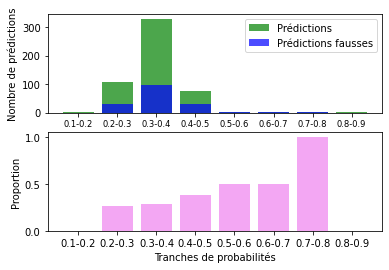

In [291]:
x = np.array([str(it)+'-'+str(round((it+0.1)*10)/10)for it in total_proba_counter.keys()])
y_testing = np.array([it for it in total_proba_counter.values()])
y_error = []
for it in total_proba_counter.keys():
    if it in error_proba_counter :
        y_error.append(error_proba_counter[it])
    else :
        y_error.append(0)
y_error = np.array(y_error)
y_proportion = [y_error[i] / y_testing[i] for i in range(len(y_error))]

figure = plt.figure()
plt.subplot(211)
plt.bar(range(len(y_testing)), y_testing, color ="green", alpha=0.7, label='Prédictions')
plt.bar(range(len(y_error)), y_error, color ="blue", alpha=0.7, label='Prédictions fausses')
plt.ylabel("Nombre de prédictions")
plt.xlabel("Taille de la phrase")
plt.xticks(range(len(y_testing)), x, size='small')
plt.legend(loc='best')

plt.subplot(212)
plt.bar(x, y_proportion, color ="violet", alpha=0.7)
plt.ylabel("Proportion")
plt.xlabel("Tranches de probabilités")
plt.show()
figure.savefig(os.getcwd() + '/data/fig/CoLa_results_regression__vec_proba_2.png', bbox_inches='tight')

## Error

In [292]:
print(error_sentences_regression[:10])

[(['as', 'you', 'eat', 'the', 'most', ',', 'you', 'want', 'the', 'least', '.'], 4), (['the', 'more', 'you', 'would', 'want', ',', 'the', 'less', 'you', 'would', 'eat', '.'], 5), (['i', 'demand', 'that', 'the', 'more', 'john', 'eat', ',', 'the', 'more', 'he', 'pays', '.'], 6), (['the', 'more', 'does', 'bill', 'smoke', ',', 'the', 'more', 'susan', 'hates', 'him', '.'], 13), (['who', 'does', 'john', 'visit', 'sally', 'because', 'he', 'likes', '?'], 16), (['mickey', 'looked', 'up', 'it', '.'], 23), (['the', 'box', 'contained', 'the', 'ball', 'from', 'the', 'tree', '.'], 28), (['the', 'tube', 'was', 'escaped', 'by', 'gas', '.'], 29), (['what', 'the', 'water', 'did', 'to', 'the', 'bottle', 'was', 'fill', 'it', '.'], 32), (['what', 'the', 'water', 'did', 'to', 'the', 'whole', 'bottle', 'was', 'fill', 'it', '.'], 33)]


# Grammar

In [293]:
import spacy
from spacy.symbols import nsubj, VERB, dobj, NOUN, PROPN

In [294]:
training_sentences_grammar = []
counter_training_sentences_grammar = {}

testing_sentences_grammar = []
counter_testing_sentences_grammar = {}

In [295]:
model_lg = spacy.load('en_core_web_lg')

In [296]:
print(error_sentences_regression[0][0])

['as', 'you', 'eat', 'the', 'most', ',', 'you', 'want', 'the', 'least', '.']


In [297]:
from pathlib import Path
doc = model_lg(' '.join(error_sentences_regression[0][0]))
svg = spacy.displacy.render(doc, style='dep',jupyter=False)
output_path = Path(os.getcwd() + '/data/fig/CoLa_grammar_example.svg') # you can keep there only "dependency_plot.svg" if you want to save it in the same folder where you run the script 
output_path.open("w", encoding="utf-8").write(svg)

7169

In [298]:
def get_grammar(sentences_list_tokenized) :
    data = []
    for tokens in sentences_list_tokenized :
        data.append([])
        sentence = model_lg(' '.join(tokens))
        for token in sentence :
            data[-1].append(token.pos_)
    return data

In [299]:
training_sentences_grammar = get_grammar(training_sentences_tokenized)
testing_sentences_grammar = get_grammar(test_sentences_tokenized)
counter_training_sentences_grammar = Counter([len(it) for it in training_sentences_grammar])
counter_testing_sentences_grammar = Counter([len(it) for it in testing_sentences_grammar])

In [300]:
print(training_sentences_grammar)

[['PRON', 'NOUN', 'AUX', 'PART', 'VERB', 'DET', 'NOUN', 'PUNCT', 'VERB', 'ADV', 'DET', 'ADJ', 'NOUN', 'PRON', 'VERB', 'PUNCT'], ['NUM', 'ADJ', 'ADJ', 'NOUN', 'CCONJ', 'PRON', 'AUX', 'AUX', 'VERB', 'ADP', 'PUNCT'], ['NUM', 'ADJ', 'ADJ', 'NOUN', 'CCONJ', 'PRON', 'AUX', 'AUX', 'VERB', 'ADP', 'PUNCT'], ['DET', 'ADV', 'PRON', 'VERB', 'NOUN', 'PUNCT', 'DET', 'ADJ', 'PRON', 'VERB', 'PUNCT'], ['NOUN', 'ADP', 'NOUN', 'DET', 'NOUN', 'AUX', 'VERB', 'ADJ', 'PUNCT'], ['PRON', 'AUX', 'VERB', 'PRON', 'DET', 'NOUN', 'PUNCT'], ['PROPN', 'VERB', 'DET', 'NOUN', 'ADJ', 'PUNCT'], ['NOUN', 'VERB', 'PRON', 'NOUN', 'SCONJ', 'ADP', 'DET', 'NOUN', 'PUNCT'], ['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'ADV', 'PUNCT'], ['PROPN', 'VERB', 'DET', 'NOUN', 'ADJ', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'ADJ', 'PUNCT'], ['NOUN', 'VERB', 'SCONJ', 'ADP', 'DET', 'NOUN', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADJ', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'DET

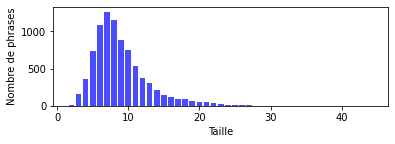

In [301]:
x = [it for it in counter_training_sentences_grammar.keys()]
y1 = [it for it in counter_training_sentences_grammar.values()]

plt.subplot(211)
plt.bar(x, y1, color ="blue",alpha=0.7)
plt.ylabel("Nombre de phrases")
plt.xlabel("Taille")
plt.show()

In [302]:
print(training_sentences_grammar)

[['PRON', 'NOUN', 'AUX', 'PART', 'VERB', 'DET', 'NOUN', 'PUNCT', 'VERB', 'ADV', 'DET', 'ADJ', 'NOUN', 'PRON', 'VERB', 'PUNCT'], ['NUM', 'ADJ', 'ADJ', 'NOUN', 'CCONJ', 'PRON', 'AUX', 'AUX', 'VERB', 'ADP', 'PUNCT'], ['NUM', 'ADJ', 'ADJ', 'NOUN', 'CCONJ', 'PRON', 'AUX', 'AUX', 'VERB', 'ADP', 'PUNCT'], ['DET', 'ADV', 'PRON', 'VERB', 'NOUN', 'PUNCT', 'DET', 'ADJ', 'PRON', 'VERB', 'PUNCT'], ['NOUN', 'ADP', 'NOUN', 'DET', 'NOUN', 'AUX', 'VERB', 'ADJ', 'PUNCT'], ['PRON', 'AUX', 'VERB', 'PRON', 'DET', 'NOUN', 'PUNCT'], ['PROPN', 'VERB', 'DET', 'NOUN', 'ADJ', 'PUNCT'], ['NOUN', 'VERB', 'PRON', 'NOUN', 'SCONJ', 'ADP', 'DET', 'NOUN', 'PUNCT'], ['PRON', 'AUX', 'VERB', 'DET', 'NOUN', 'ADV', 'PUNCT'], ['PROPN', 'VERB', 'DET', 'NOUN', 'ADJ', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'ADJ', 'PUNCT'], ['NOUN', 'VERB', 'SCONJ', 'ADP', 'DET', 'NOUN', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADJ', 'PUNCT'], ['DET', 'NOUN', 'VERB', 'DET

## With Word2Vec

In [303]:
grammar_2vec_model = define_model(training_sentences_grammar, 2, 5)
training_sentences_grammar_embedded = transform_to_vec(grammar_2vec_model, training_sentences_grammar, 20, 5)
test_sentences_grammar_embedded = transform_to_vec(grammar_2vec_model, testing_sentences_grammar, 20, 5)
clf_regression = train(training_sentences_grammar_embedded, training_sentences_label)
accuracy, error_regression_size, error_sentences_regression, error_regression_proba, total_proba = test(grammar_2vec_model,clf_regression, test_sentences_grammar_embedded)

In [304]:
print(accuracy)

69.63946869070209


In [305]:
def round_list(data:list) :
    newList = []
    for i in range(len(data)) :
        newList.append(round(data[i]*10)/10)
    return newList

error_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(error_regression_proba)).items())))
total_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(total_proba)).items())))
print(error_proba_counter)
print(total_proba_counter)

{0.1: 1, 0.2: 28, 0.3: 110, 0.4: 19, 0.6: 1, 0.7: 1}
{0.1: 1, 0.2: 104, 0.3: 355, 0.4: 58, 0.5: 5, 0.6: 3, 0.7: 1}


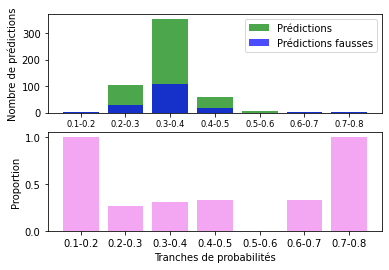

In [311]:
x = np.array([str(it)+'-'+str(round((it+0.1)*10)/10) for it in total_proba_counter.keys()])
y_testing = np.array([it for it in total_proba_counter.values()])
y_error = []
for it in total_proba_counter.keys():
    if it in error_proba_counter :
        y_error.append(error_proba_counter[it])
    else :
        y_error.append(0)
y_error = np.array(y_error)
y_proportion = [y_error[i] / y_testing[i] for i in range(len(y_error))]

figure = plt.figure()
plt.subplot(211)
plt.bar(range(len(y_testing)), y_testing, color ="green", alpha=0.7, label='Prédictions')
plt.bar(range(len(y_error)), y_error, color ="blue", alpha=0.7, label='Prédictions fausses')
plt.ylabel("Nombre de prédictions")
plt.xlabel("Taille de la phrase")
plt.xticks(range(len(y_testing)), x, size='small')
plt.legend(loc='best')

plt.subplot(212)
plt.bar(x, y_proportion, color ="violet", alpha=0.7)
plt.ylabel("Proportion")
plt.xlabel("Tranches de probabilités")
plt.show()
figure.savefig(os.getcwd() + '/data/fig/CoLa_results_regression__vec__grammar_proba.png', bbox_inches='tight')

In [ ]:
print(test_sentences_grammar_embedded[0])
print(grammar_2vec_model.wv.most_similar("PRON"))

In [ ]:
print(error_sentences_regression[:10])

In [ ]:
result_data_sentence = []
resulta_data_grammar = []
label_error = []
for tokens in error_sentences_regression :
    label_error.append(test_sentences_label[tokens[1]])
    result_data_sentence.append(tokens[0])
    resulta_data_grammar.append([])
    sentence = model_lg(' '.join(tokens[0]))
    for token in sentence :
        resulta_data_grammar[-1].append(token.pos_)
print(result_data_sentence)
print(resulta_data_grammar)

## Result study

In [315]:
print(label_error)
all_found = []
index_list = [k[1] for k in error_sentences_regression]
for i, it in enumerate(test_sentences_label) :
    if i not in index_list :
        all_found.append(it)
print(all_found)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [316]:
count_0 = 0
for it in training_sentences_label :
    if not it : 
        count_0 += 1
print(count_0)
print(len(training_sentences_label) - count_0)
print(len(training_sentences_label))

2528
6023
8551


In [ ]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    labels = []
    tokens = []
    
    for word in model.wv.key_to_index:
        
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
tsne_plot(grammar_2vec_model)

## Without Word2Vec

In [ ]:
vocab = create_vocabulary(training_sentences_grammar)
print(len(vocab))
print(vocab)

In [ ]:
training_sentences_grammar_sequenced = apply_text_transformation(vocab, training_sentences_grammar) # encode word in all sentences
test_sentences_grammar_sequenced = apply_text_transformation(vocab, testing_sentences_grammar)

normalize_vector_size(25, training_sentences_grammar_sequenced) # normalize with
normalize_vector_size(25, test_sentences_grammar_sequenced) # normalize with

In [ ]:
x = np.array(training_sentences_grammar_sequenced, dtype=object)
y = np.array(training_sentences_label)
print(x.shape)
print(y.shape)


In [ ]:
clf_regression = LogisticRegression(random_state=0)
clf_regression.fit(x, y)

In [ ]:
error_regression_size = []
error_sentences_regression = []
error_regression_proba = []
total_proba = []
for i, test_tokens in enumerate(test_sentences_grammar_sequenced) :
    proba = clf_regression.predict_proba([test_tokens])[0][0]
    total_proba.append(proba)
    if clf_regression.predict([test_tokens]) != test_sentences_label[i] :
        error_regression_size.append(len(test_sentences_tokenized[i]))
        error_regression_proba.append(proba)
        error_sentences_regression.append((test_tokens, i))
print(100 - len(error_regression_size) * 100 / len(total_proba))

In [ ]:
error_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(error_regression_proba)).items())))
total_proba_counter = dict(collections.OrderedDict(sorted(Counter(round_list(total_proba)).items())))

In [ ]:
x = np.array([str(it) for it in total_proba_counter.keys()])
y_testing = np.array([it for it in total_proba_counter.values()])
y_error = []
for it in total_proba_counter.keys():
    if it in error_proba_counter :
        y_error.append(error_proba_counter[it])
    else :
        y_error.append(0)
y_error = np.array(y_error)
y_proportion = [y_error[i] / y_testing[i] for i in range(len(y_error))]

figure = plt.figure()
plt.subplot(211)
plt.bar(range(len(y_testing)), y_testing, color ="green", alpha=0.7, label='Prédictions')
plt.bar(range(len(y_error)), y_error, color ="blue", alpha=0.7, label='Prédictions fausses')
plt.ylabel("Nombre de prédictions")
plt.xlabel("Taille de la phrase")
plt.xticks(range(len(y_testing)), x, size='small')
plt.legend(loc='best')

plt.subplot(212)
plt.bar(x, y_proportion, color ="violet", alpha=0.7)
plt.ylabel("Proportion")
plt.xlabel("Tranches de probabilités")
plt.show()

In [ ]:
print(error_proba_counter)

## SVM

In [ ]:
x = np.array(training_sentences_grammar_sequenced, dtype=object)
y = np.array(training_sentences_label)
print(x.shape)
print(y.shape)
clf_svm = make_pipeline(StandardScaler(), SVC(kernel='sigmoid', gamma='scale'))
clf_svm.fit(x, y)

In [ ]:
error_svm = []
error_sentences_svm = []
for i, test_tokens in enumerate(test_sentences_sequenced) :
    if clf_svm.predict([test_tokens]) != test_sentences_label[i] :
        error_svm.append(len(test_sentences_tokenized[i]))
        error_sentences_svm.append((test_tokens, i))
print(100 - len(error_svm)*100 / len(test_sentences_label))

## Shuffle

In [ ]:
new_training_data = []
i = 0
while len(new_training_data) < 2528 : 
    if training_sentences_label[i] == 1 :
        new_training_data.append((training_sentences_tokenized[i], 1))
    i += 1
for i,it in enumerate(training_sentences_tokenized) :
      if not training_sentences_label[i] :
            new_training_data.append((training_sentences_tokenized[i],0))
print(new_training_data)

In [ ]:
import random
random.shuffle(new_training_data)
label_list = [it[1] for it in new_training_data]
data_list = [it[0] for it in new_training_data]

## Grammar

In [ ]:
training_sentences_grammar = get_grammar(data_list)
testing_sentences_grammar = get_grammar(test_sentences_tokenized)
counter_training_sentences_grammar = Counter([len(it) for it in training_sentences_grammar])
counter_testing_sentences_grammar = Counter([len(it) for it in testing_sentences_grammar])

In [ ]:
grammar_2vec_model = define_model(training_sentences_grammar, 2, 5)
training_sentences_grammar_embedded = transform_to_vec(grammar_2vec_model, training_sentences_grammar, 20, 5)
test_sentences_grammar_embedded = transform_to_vec(grammar_2vec_model, testing_sentences_grammar, 20, 5)
clf_regression = train(training_sentences_grammar_embedded, label_list)
accuracy, error_regression_size, error_sentences_regression, error_regression_proba, total_proba = test(grammar_2vec_model,clf_regression, test_sentences_grammar_embedded)

In [ ]:
print(accuracy)

## Just Word2vec

In [ ]:
model = define_model(data_list, 4, 5)
training_sentences_embedded = transform_to_vec(model, data_list, 25, 5)
test_sentences_embedded = transform_to_vec(model, test_sentences_tokenized, 25, 5)
clf_regression = train(training_sentences_embedded, label_list)
accuracy, error_regression_size, error_sentences_regression, error_regression_proba, total_proba = test(model,clf_regression, test_sentences_embedded)

In [ ]:
print(accuracy)

In [ ]:
label_error = []
all_found = []
index_list = [k[1] for k in error_sentences_regression]
for tokens in error_sentences_regression :
    label_error.append(test_sentences_label[tokens[1]])
                                            
for i, it in enumerate(test_sentences_label) :
    if i not in index_list :
        all_found.append(it)
error_counter = Counter(label_error)
found_counter = Counter(all_found)
print(error_counter)
print(found_counter)